In [126]:
import numpy as np
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt
from sklearn import datasets

In [131]:
def e(i, d):
    ei = np.zeros(d)
    ei[i] = 1
    return ei



def KWSA(F, w, m, c, d):
    """ 
    Kiefer-Wolfowitz stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample size (null in this case)
    - d: dimension
    - c: costant
    
    """

    F_wc = np.array([F(w + c * e(i, d)) for i in range(d)])
    return (F_wc - F(w)) / c



def IRDSA(F, w, m, c, d):
    """ 
    Improvised Random Direction stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample dimension
    - d: features dimension
    - c: costant
    
    """
    z = np.random.normal(0, 1, (d, m))
    F_w = F(w)
    return np.mean([(F(w + c * z[:,i]) - F_w) / c * z[:,i] for i in range(m)], axis = 0)
    
    


def detZFW(F, L, d, w0, r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - L: Lip constant
    - d: dimension
    - w0: starting point
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """

    gamma = lambda t: 2/(t+2)
    c = lambda t: L*gamma(t)/d
    w = w0
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = KWSA(F, w, None, c(t), d)
        # compute the linear problem solution on the L1 Ball of radius r
        ei = e(np.argmax(np.abs(gt)), d) * r
        v = np.sign(-gt) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = F(w_pred) - F(w)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t

## Stochastic lasso regression

In [3]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [128]:
# space dimension
d = X.shape[1]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [129]:
# define the objective function
F = lambda w: 0.5 * np.sum(np.power(y - X @ w, 2))

In [130]:
# initialize prarameters for the algorithm

# stating point 
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/sum(w0)
#print(w0)
#print(F(w0))

# Lipschitz constant computation
L = 2/X.shape[0] * norm(X.T @ X)
print(f"L: {L}")

L: 6.401824257555926


In [133]:
%%time
fpred, f, w, mean, t = detZFW(F, L, d, w0, T=200)

Loss evaluation at time 1:	320442.8827

Loss evaluation at time 2:	57384.8266

Loss evaluation at time 3:	20408.6305

Loss evaluation at time 4:	9658.8938

Loss evaluation at time 5:	5356.1125

Loss evaluation at time 6:	3287.2771

Loss evaluation at time 7:	2165.7518

Loss evaluation at time 8:	1503.7615

Loss evaluation at time 9:	1087.3006

Loss evaluation at time 10:	811.9696

Loss evaluation at time 11:	622.5471

Loss evaluation at time 12:	487.8967

Loss evaluation at time 13:	389.5270

Loss evaluation at time 14:	315.9734

Loss evaluation at time 15:	259.8651

Loss evaluation at time 16:	216.3140

Loss evaluation at time 17:	181.9897

Loss evaluation at time 18:	154.5695

Loss evaluation at time 19:	132.3991

Loss evaluation at time 20:	114.2785

Loss evaluation at time 21:	99.3227

Loss evaluation at time 22:	86.8693

Loss evaluation at time 23:	76.4157

Loss evaluation at time 24:	67.5755

Loss evaluation at time 25:	60.0491

Loss evaluation at time 26:	53.6009

Loss evaluatio

In [145]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

F(w_pred) = 181525.35998540587

F(w) = 181548.68696763652

w = [ 5.23105600e-05  1.57315358e-06  1.20546499e-08  1.41221084e-06
  8.57775646e-05  1.66030158e-04  1.17959417e-01  8.79298339e-01
  1.74521049e-03  2.87057150e-05  5.17760294e-04  3.39823294e-07
  5.67333862e-07  1.01727444e-06  9.63924717e-07  1.88822163e-06
  1.54709061e-06  2.07782710e-08  6.38127397e-07  6.93596671e-07
  1.61734925e-06  1.37340846e-06  1.56981352e-06  1.64692333e-07
  1.91960787e-06  1.94429340e-06  1.41479562e-06  3.39840463e-07
 -1.48618898e-05  7.39830121e-07  1.90022630e-06  3.50408370e-07
  1.59961095e-06  9.77132823e-07  3.65768893e-07  6.18041258e-07
  1.46576628e-06  1.82041291e-07  1.04983792e-06  1.99076184e-07
  1.66399033e-06  1.93561704e-06  8.94293116e-07  4.80759533e-07
  4.23719196e-07  3.12150923e-05  1.41407182e-06  2.53136805e-05
  1.05644808e-06  1.02601942e-07  3.38289454e-07  3.19891704e-05
  8.41086607e-07  1.65207175e-06]

average w = [ 2.08459174e-03  1.98020707e-04  1.51737905e

## Stochastic Gradient Free Frank Wolfe

In [138]:
def stochasticZFW(F, d,  w0, method = "IRDSA", r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - method: zeroth order oracle
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    Parameters_dict = {"KWSA": {"m": None, 
                                "c": lambda t: 2 / (np.sqrt(d) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / np.power(t+8, 2/3),
                                "oracle": KWSA},
                       
                   
                       "RDSA": {"m": 1, 
                                "c": lambda t: 2 / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(d, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA},
                   
                       "IRDSA": {"m": 6, 
                                "c": lambda t: 2 * np.sqrt(6) / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(1+d/6, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA}
                  
                        }
    
    return sZFW(F, d, w0, Parameters_dict[method], r, T, eps)
    
  

    
def sZFW(F, d, w0, params, r, T, eps):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - params: dict of parameters for the selected method
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    loss = []
    gamma = lambda t: 2/(t+8)
    w = w0
    dt = np.zeros(d)
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = params["oracle"](F, w, params["m"], params["c"](t), d)
        dt = (1 - params["p"](t)) * dt + params["p"](t) * gt
        # compute the linear problem solution on the L1 Ball of radius r
        ei = e(np.argmax(np.abs(dt)), d) * r
        v = np.sign(-dt) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.4f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss


In [139]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "IRDSA", r=1, T=1000, eps=1e-5)

Loss evaluation at time 1:	23485.3026

Loss evaluation at time 2:	118187.9164

Loss evaluation at time 3:	77077.7907

Loss evaluation at time 4:	9683.7472

Loss evaluation at time 5:	36613.9823

Loss evaluation at time 6:	50942.6387

Loss evaluation at time 7:	8156.1616

Loss evaluation at time 8:	22736.7139

Loss evaluation at time 9:	25373.2420

Loss evaluation at time 10:	43955.3835

Loss evaluation at time 11:	35083.8555

Loss evaluation at time 12:	3283.3129

Loss evaluation at time 13:	26776.8020

Loss evaluation at time 14:	740.9106

Loss evaluation at time 15:	21462.7202

Loss evaluation at time 16:	18111.1744

Loss evaluation at time 17:	15421.5570

Loss evaluation at time 18:	13239.2585

Loss evaluation at time 19:	1806.8469

Loss evaluation at time 20:	9649.7009

Loss evaluation at time 21:	8900.0339

Loss evaluation at time 22:	8210.9718

Loss evaluation at time 23:	12445.3037

Loss evaluation at time 24:	11009.7996

Loss evaluation at time 25:	9365.5445

Loss evaluation at

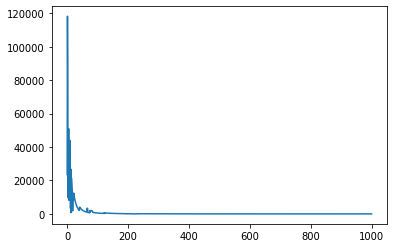

In [144]:
plt.plot(loss)

In [142]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

F(w_pred) = 181525.35998540587

F(w) = 181548.68696763652

w = [ 5.23105600e-05  1.57315358e-06  1.20546499e-08  1.41221084e-06
  8.57775646e-05  1.66030158e-04  1.17959417e-01  8.79298339e-01
  1.74521049e-03  2.87057150e-05  5.17760294e-04  3.39823294e-07
  5.67333862e-07  1.01727444e-06  9.63924717e-07  1.88822163e-06
  1.54709061e-06  2.07782710e-08  6.38127397e-07  6.93596671e-07
  1.61734925e-06  1.37340846e-06  1.56981352e-06  1.64692333e-07
  1.91960787e-06  1.94429340e-06  1.41479562e-06  3.39840463e-07
 -1.48618898e-05  7.39830121e-07  1.90022630e-06  3.50408370e-07
  1.59961095e-06  9.77132823e-07  3.65768893e-07  6.18041258e-07
  1.46576628e-06  1.82041291e-07  1.04983792e-06  1.99076184e-07
  1.66399033e-06  1.93561704e-06  8.94293116e-07  4.80759533e-07
  4.23719196e-07  3.12150923e-05  1.41407182e-06  2.53136805e-05
  1.05644808e-06  1.02601942e-07  3.38289454e-07  3.19891704e-05
  8.41086607e-07  1.65207175e-06]

average w = [ 2.08459174e-03  1.98020707e-04  1.51737905e

## Zeroth order stochastic accelerated gradient method with inexact updates

In [ ]:
def InexactUpdate(F, d, v, m, gamma, mu):
    """
    INPUT
    - F: loss function
    - d: dimension
    - v: starting point
    - m: sample size
    - gamma: decreasing coefficient
    - mu: threshold
    """
    
    haty = v
    t = 1
    while True:
        # ARGMIN PROBLEM
        yt = 
        
        if h(yt) >= - mu:
            break
        else:
            haty = (t-1)/(t+1) * haty + 2/(t+1)*yt
            t +=1
    
    return haty
    

    
def IZFW(F, d, w0, c, r = 1, T = 100, eps = 1e-6):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - m: sample size
    - c: smoothing parameter (now fixed)
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    alpha = lambda t: 2/(t+1)
    gamma = lambda t: 4*L/t
    mu = lambda t: L*D/(t*T)
    m = t * (t+1) / D * np.max([(d+5)*B*T, d+3])
    c = 1 / (np.sqrt(2*T)) * np.max([1/(d+3), np.sqrt(D/(d*(T+1)))])
    
    
    IRDSA(F, w, m, c, d)
